<a href="https://colab.research.google.com/github/SrishtiiSrivastava/CD101/blob/master/Transformer_winetestingallthree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load the Wine Quality Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Preprocessing
X = data.drop('quality', axis=1)
y = (data['quality'] >= 6).astype(int)  # Good wine if quality >= 6, else bad wine

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for transformer model (add extra dimension for sequence)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [2]:
# Define Self-Attention Layer
class SelfAttention(layers.Layer):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.query_dense = layers.Dense(embed_size)
        self.key_dense = layers.Dense(embed_size)
        self.value_dense = layers.Dense(embed_size)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        score = tf.matmul(query, key, transpose_b=True) / tf.sqrt(float(self.embed_size))
        attention_weights = tf.nn.softmax(score, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output

# Define Transformer Encoder Layer
def transformer_encoder(embed_size, ff_dim):
    inputs = layers.Input(shape=(None, embed_size))
    attention_output = SelfAttention(embed_size)(inputs)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    ff_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ff_output = layers.Dense(embed_size)(ff_output)
    output = layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)
    return models.Model(inputs=inputs, outputs=output)

# Build the model
embed_size = X_train.shape[-1]  # 1 in this case (sequence length = 1)
ff_dim = 64
inputs = layers.Input(shape=(X_train.shape[1], embed_size))
encoder = transformer_encoder(embed_size, ff_dim)
encoder_output = encoder(inputs)
flattened = layers.GlobalAveragePooling1D()(encoder_output)
output = layers.Dense(1, activation='sigmoid')(flattened)
model = models.Model(inputs, output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5594 - val_loss: 0.6911
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5326 - loss: 0.6920 - val_accuracy: 0.5594 - val_loss: 0.6900
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5269 - loss: 0.6920 - val_accuracy: 0.5594 - val_loss: 0.6897
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5091 - loss: 0.6931 - val_accuracy: 0.5594 - val_loss: 0.6891
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5238 - loss: 0.6920 - val_accuracy: 0.5594 - val_loss: 0.6886
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5267 - loss: 0.6918 - val_accuracy: 0.5594 - val_loss: 0.6885
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5474 - loss: 0.6896 - val_accuracy: 0.5594 - val_loss: 0.6881
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5354 - loss: 0.6908 - val_accuracy: 0.5594 - val_loss

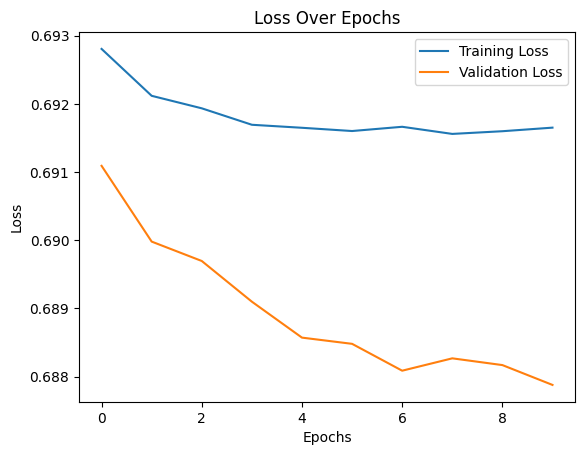

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
def predict_wine_quality(features):
    # Normalize the input features
    features_scaled = scaler.transform([features])
    features_scaled = features_scaled.reshape((features_scaled.shape[0], features_scaled.shape[1], 1))

    # Predict the wine quality
    prediction = model.predict(features_scaled)
    predicted_quality = "Good" if prediction[0] >= 0.5 else "Bad"
    return predicted_quality

# Test the model on a new wine sample
new_wine = [7.4, 0.70, 0.00, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]  # Example features
predicted_quality = predict_wine_quality(new_wine)

print(f"The predicted quality of the wine is: {predicted_quality}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
The predicted quality of the wine is: Good


In [ ]:
Example of CNN

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical


# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Load the Wine Quality Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Select features and target
X = data.drop('quality', axis=1).values  # Features are all columns except 'quality'
y = data['quality'].values  # The target is the 'quality' column

# Create a binary classification problem
# Wine quality >= 6 is labeled 1 (high quality), otherwise 0 (low quality)
y = np.where(y >= 6, 1, 0)  # Binary classification target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features to ensure they are in the 0-1 range
X_train = X_train / X_train.max(axis=0)
X_test = X_test / X_test.max(axis=0)

# Reshape tabular data into pseudo-images suitable for CNN input
num_features = X_train.shape[1]  # Number of features (columns) in the tabular data
X_train_cnn = X_train.reshape(-1, num_features, 1, 1)  # Shape into (num_features, 1, 1)
X_test_cnn = X_test.reshape(-1, num_features, 1, 1)

# Print to confirm reshaping
print("Reshaped Training Data Shape:", X_train_cnn.shape)
print("Reshaped Test Data Shape:", X_test_cnn.shape)




Reshaped Training Data Shape: (1279, 11, 1, 1)
Reshaped Test Data Shape: (320, 11, 1, 1)


In [ ]:
# Define CNN Model
def create_cnn_model():
    model = Sequential([
        Input(shape=(num_features, 1, 1)),  # Input shape matches reshaped data
        Conv2D(16, (2, 1), activation='relu'),  # Apply convolution
        MaxPooling2D(pool_size=(2, 1)),  # Max pooling to reduce dimensionality
        Flatten(),  # Flatten the output for the dense layer
        Dense(64, activation='relu'),  # Hidden dense layer
        Dense(1, activation='sigmoid')  # Binary classification output
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = create_cnn_model()

# Model summary for review
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 10, 1, 16)           │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,297 (20.69 KB)

 Trainable params: 5,297 (20.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train,
                         validation_data=(X_test_cnn, y_test),
                         epochs=10,
                         batch_size=32,
                         verbose=2)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/10
40/40 - 2s - 44ms/step - accuracy: 0.5387 - loss: 0.6884 - val_accuracy: 0.6062 - val_loss: 0.6772
Epoch 2/10
40/40 - 0s - 9ms/step - accuracy: 0.5645 - loss: 0.6776 - val_accuracy: 0.5781 - val_loss: 0.6657
Epoch 3/10
40/40 - 0s - 3ms/step - accuracy: 0.5880 - loss: 0.6702 - val_accuracy: 0.5625 - val_loss: 0.6584
Epoch 4/10
40/40 - 0s - 3ms/step - accuracy: 0.6192 - loss: 0.6561 - val_accuracy: 0.6562 - val_loss: 0.6463
Epoch 5/10
40/40 - 0s - 4ms/step - accuracy: 0.6294 - loss: 0.6453 - val_accuracy: 0.6438 - val_loss: 0.6299
Epoch 6/10
40/40 - 0s - 3ms/step - accuracy: 0.6740 - loss: 0.6285 - val_accuracy: 0.6375 - val_loss: 0.6198
Epoch 7/10
40/40 - 0s - 3ms/step - accuracy: 0.6826 - loss: 0.6144 - val_accuracy: 0.6594 - val_loss: 0.6048
Epoch 8/10
40/40 - 0s - 4ms/step - accuracy: 0.6818 - loss: 0.6034 - val_accuracy: 0.6562 - val_loss: 0.6093
Epoch 9/10
40/40 - 0s - 7ms/step - accuracy: 0.6880 - loss: 0.5904 - val_accuracy: 0.6594 - val_loss: 0.5878
Epoch 10/10
40/40 

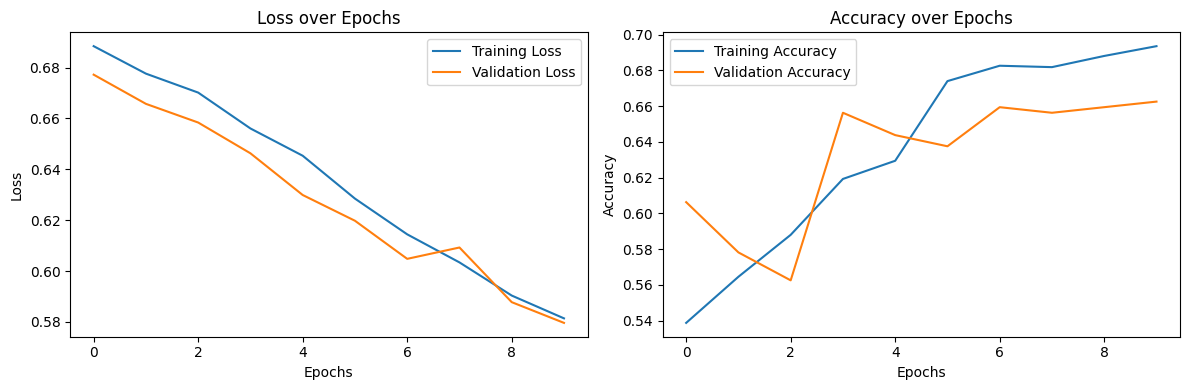

In [ ]:
import matplotlib.pyplot as plt

# Plotting training history
plt.figure(figsize=(12, 4))

# Plot loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Test the CNN model with a new sample
def test_cnn_sample(model, X_sample, y_sample):
    # Predict on test sample
    predictions = model.predict(X_sample)  # Model predictions

    # Apply a 0.5 threshold to classify
    predicted_classes = (predictions >= 0.5).astype(int).flatten()
    true_classes = y_sample.flatten()

    # Compare predictions to actual labels
    correct = np.sum(predicted_classes == true_classes)
    accuracy = correct / len(true_classes) * 100

    print(f"Predictions: {predicted_classes}")
    print(f"Actual Labels: {true_classes}")
    print(f"Correct Predictions: {correct}")
    print(f"Prediction Accuracy: {accuracy:.2f}%")

# Select a small test sample for demonstration
# Using only a few random samples from the test set
sample_indices = np.random.choice(len(X_test_cnn), size=10, replace=False)
X_sample = X_test_cnn[sample_indices]
y_sample = y_test[sample_indices]

# Call the testing function
test_cnn_sample(cnn_model, X_sample, y_sample)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predictions: [1 1 0 1 1 0 1 1 1 1]
Actual Labels: [0 1 0 0 1 1 1 1 1 0]
Correct Predictions: 6
Prediction Accuracy: 60.00%


In [ ]:
For autoencoders

Epoch 1/10
32/32 - 2s - 47ms/step - loss: 0.5470 - val_loss: 0.4915
Epoch 2/10
32/32 - 0s - 5ms/step - loss: 0.4962 - val_loss: 0.4267
Epoch 3/10
32/32 - 0s - 9ms/step - loss: 0.4180 - val_loss: 0.3529
Epoch 4/10
32/32 - 0s - 4ms/step - loss: 0.3613 - val_loss: 0.3174
Epoch 5/10
32/32 - 0s - 5ms/step - loss: 0.3365 - val_loss: 0.3021
Epoch 6/10
32/32 - 0s - 9ms/step - loss: 0.3238 - val_loss: 0.2924
Epoch 7/10
32/32 - 0s - 5ms/step - loss: 0.3131 - val_loss: 0.2829
Epoch 8/10
32/32 - 0s - 9ms/step - loss: 0.3024 - val_loss: 0.2746
Epoch 9/10
32/32 - 0s - 4ms/step - loss: 0.2960 - val_loss: 0.2701
Epoch 10/10
32/32 - 0s - 4ms/step - loss: 0.2920 - val_loss: 0.2671
Reconstruction Loss: 0.2779


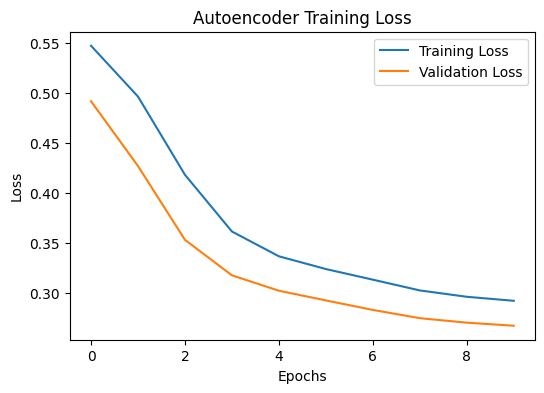

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


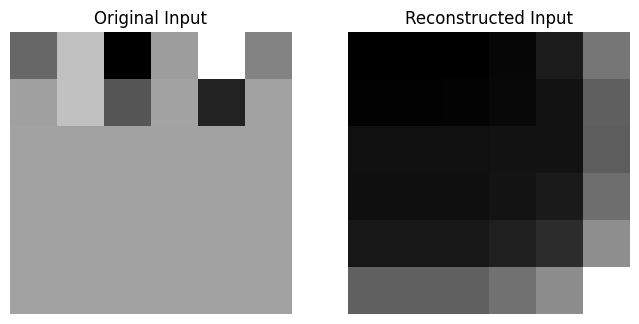

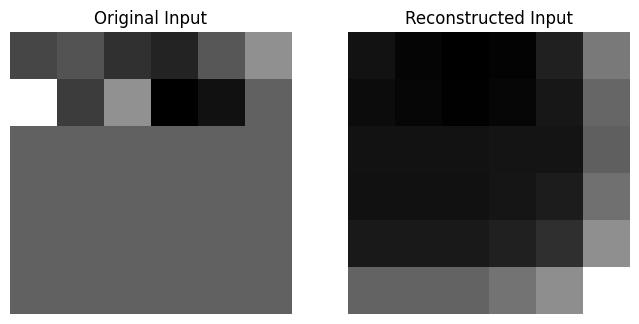

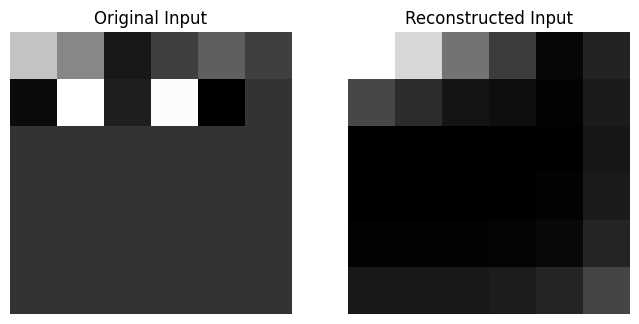

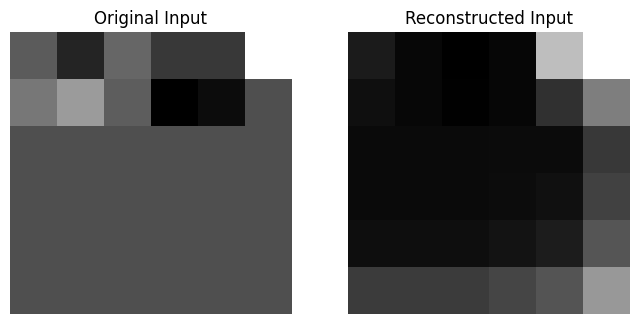

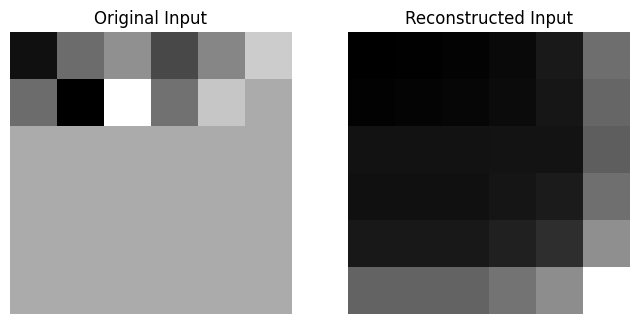

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D


# Load & Preprocess the Wine Quality Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=['quality']).values)  # Feature scaling

# Reshape features into CNN-compatible pseudo-images for Autoencoder
num_features = X.shape[1]
target_shape = (6, 6, 1)

X_padded = np.zeros((X.shape[0], target_shape[0] * target_shape[1]))
X_padded[:, :num_features] = X
X_cnn = X_padded.reshape(-1, target_shape[0], target_shape[1], 1)

# Split train-test splits
X_train, X_test = train_test_split(X_cnn, test_size=0.2, random_state=42)[0], train_test_split(X_cnn, test_size=0.2, random_state=42)[1]


# Create Autoencoder Model
def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(8, (2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


# Initialize Autoencoder
autoencoder = create_autoencoder(input_shape=(6, 6, 1))

# Train the Autoencoder
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the Autoencoder
loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Reconstruction Loss: {loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


# Testing Exercise for Autoencoder
def test_autoencoder(model, X_test):
    reconstructed = model.predict(X_test)
    for i in range(5):  # Display 5 examples for visual comparison
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Original Input")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Input")
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        plt.axis('off')

        plt.show()


# Run the Testing Exercise
test_autoencoder(autoencoder, X_test)
